In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_set_folder = 'UrbanSound8K/sound_data'
test_data_set_folder = 'UrbanSound8K/sound_data/fold10'
black_list_folders = ['fold10'] # reserve for validation set
import_folder_paths = []
target_wav_duration = 2.97
wav_data_shape_x = 128
wav_data_shape_y = 128
batch_size = 128
epochs = 40

In [3]:
def extract_feature(file_path):
    y, sr = librosa.load(file_path, duration=target_wav_duration)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (wav_data_shape_x, wav_data_shape_y):
        return None, None
    return ps, sr

def import_sound_data(folder_path):
    imported_count = 0
    imported_data_set = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_name, file_extension = os.path.splitext(file)
            if file_extension != '.wav': continue
            file_path = os.path.join(root, file)
            ps, sr = extract_feature(file_path)
            if sr == None:
                continue
            class_id = file.split('-')[1]
            imported_data_set.append((ps, class_id))
            imported_count += 1
            if imported_count % 1000 == 0:
                print('Import in progress...{}'.format(imported_count))
    print('Import finish for folder:{}'.format(folder_path))
    return imported_data_set, imported_count

In [4]:
import_folder_paths = []
for root, dirnames, _ in os.walk(data_set_folder):
    for dir_name in dirnames:
        if dir_name in black_list_folders:
            continue
        wav_folder_path = os.path.join(root, dir_name)
        import_folder_paths.append(wav_folder_path)
#print('import_folder_paths:{}'.format(import_folder_paths))

### Import Train Data

In [5]:
train_data_set = []
total_import_count = 0
for folder_path in import_folder_paths:
    imported_data_set, imported_count = import_sound_data(folder_path)
    train_data_set.extend(imported_data_set)
    total_import_count += imported_count

Import in progress...1000
Import in progress...2000
Import in progress...3000
Import finish for folder:UrbanSound8K/sound_data/fold2
Import in progress...1000
Import in progress...2000
Import in progress...3000
Import in progress...4000
Import finish for folder:UrbanSound8K/sound_data/fold5
Import in progress...1000
Import in progress...2000
Import in progress...3000
Import in progress...4000
Import finish for folder:UrbanSound8K/sound_data/fold4
Import in progress...1000
Import in progress...2000
Import in progress...3000
Import in progress...4000
Import finish for folder:UrbanSound8K/sound_data/fold3
Import in progress...1000
Import in progress...2000
Import in progress...3000
Import finish for folder:UrbanSound8K/sound_data/fold8
Import in progress...1000
Import in progress...2000
Import in progress...3000
Import finish for folder:UrbanSound8K/sound_data/fold6
Import in progress...1000
Import in progress...2000
Import finish for folder:UrbanSound8K/sound_data/fold1
Import in progres

### Import Test Data

In [6]:
test_data_set = []
imported_data_set, imported_count = import_sound_data(test_data_set_folder)
test_data_set.extend(imported_data_set)

Import finish for folder:UrbanSound8K/sound_data/fold10


### Train Data Model

In [7]:
print('Train data set count:{}'.format(len(train_data_set)))
print('Test data set count:{}'.format(len(test_data_set)))

random.shuffle(train_data_set)
X_train, y_train = zip(*train_data_set)
X_test, y_test = zip(*test_data_set)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

model = Sequential()

# Input
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))

model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))

model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Output
model.add(Dense(10))
model.add(Activation('softmax'))

Train data set count:29511
Test data set count:837


In [8]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data= (X_test, y_test)
)

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 29511 samples, validate on 837 samples
Epoch 1/40
29511/29511 [==============================] - 294s 10ms/step - loss: 2.0147 - acc: 0.3211 - val_loss: 1.7072 - val_acc: 0.4062
Epoch 2/40
29511/29511 [==============================] - 259s 9ms/step - loss: 1.5296 - acc: 0.4687 - val_loss: 1.6241 - val_acc: 0.4480
Epoch 3/40
29511/29511 [==============================] - 280s 9ms/step - loss: 1.3058 - acc: 0.5484 - val_loss: 1.4323 - val_acc: 0.4886
Epoch 4/40
29511/29511 [==============================] - 268s 9ms/step - loss: 1.1388 - acc: 0.6069 - val_loss: 1.3409 - val_acc: 0.5293
Epoch 5/40
29511/29511 [==============================] - 269s 9ms/step - loss: 1.0207 - acc: 0.6526 - val_loss: 1.3153 - val_acc: 0.5795
Epoch 6/40
29511/29511 [==============================] - 270s 9ms/step - loss: 0.9895 - acc: 0.6719 - val_loss: 1.2496 - val_acc: 0.6356
Epoch 7/40
29511/29511 [==============================] - 265s 9ms/step - loss: 0.8681 - acc: 0.7048 - val_loss: 1.1784 - v

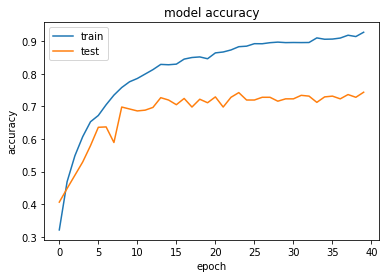

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.save('models/sound_cnn_74.h5')

### Train Data Model